# Systrace Parser

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

In [2]:
%pylab inline

import os
from time import sleep

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import Screen, Workload

from devlib.utils.android import adb_command

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy
import glob

import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

import ipywidgets as widgets
from IPython.display import display

from ipywidgets import interact, interactive, fixed, interact_manual

from android import System

import subprocess

from systrace_parser import systrace_parser

2019-04-12 05:52:44,279 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/Grammar.txt
2019-04-12 05:52:44,294 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt


Populating the interactive namespace from numpy and matplotlib


## Test environment setup

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [3]:
import os
os.environ['ANDROID_HOME'] = '/home/ubuntu/Android/AndroidSDK/'

In [4]:
conf = {
    
    # Target platform and board
    "platform"    : 'android',
    "board"       : 'pixel',

    # Device ID
    #"device"      : "HT6670300102",
    
    # Android home
    "ANDROID_HOME" : "/home/ubuntu/Android/AndroidSDK",
    
    # Lisa home
    "LISA_HOME" : "/home/ubuntu/Android/lisa",

    # Systrace home
    "SYSTRACE_HOME" : "/ipynb/performance/testingdata",
    
    "MAX_CORE_NUM" : 8
}

## Defines

In [5]:
#file_name = 'G9750/com.eg.android.AlipayGphone_1.html'
file_name = 'com.eg.android.AlipayGphone_3.html'

## Support Functions

###  ---  Trace Mark Functions

###  ---  Sched Functions

## Filters

In [6]:
trace_mark_filters = {
    'launching' : {
        'SMARK' : {'context' : 'launching:', 'type' : 'S'}, 
        'EMARK' : {'context' : 'launching:', 'type' : 'F'},
    },
    'ActivityThreadMain' : {
        'SMARK' : {'context' : 'ActivityThreadMain', 'type' : 'B'}, 
        'EMARK' : {'context' : 'ActivityThreadMain', 'type' : 'E'},
    },
    'bindApplication' : {
        'SMARK' : {'context' : 'bindApplication', 'type' : 'B'}, 
        'EMARK' : {'context' : 'bindApplication', 'type' : 'E'},
    },
    'activityStart' : {
        'SMARK' : {'context' : 'activityStart', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityStart', 'type' : 'E'},
    },
    'activityResume' : {
        'SMARK' : {'context' : 'activityResume', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityResume', 'type' : 'E'},
    },
    'Choreographer' : {
        'SMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'B'}, 
        'EMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'E'},
        'SEPERATE' : [0, 1],
    },
}

In [7]:

count = 0
dirname = ''
dirnames = ''
chboxes = list()

for (path, dir, files) in os.walk(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/'):
    if len(dir) > 0:
        dirnames = dir
    file_groups = list()
    for filename in files:
        if filename.split('.')[-1] == 'html':
            new_one = True
            for file_group in file_groups:
                length_of_file = len(filename)
                if length_of_file == len(file_group) and filename[:length_of_file/2] == file_group[:length_of_file/2]:
                    #print('before  {}'.format(file_groups))
                    file_groups.remove(file_group)
                    file_groups.append('{}?{}'.format(file_group[:-6],file_group[-5:]))
                    #print('after  {}'.format(file_groups))
                    new_one = False
                    break
            if new_one:
                file_groups.append(filename)
    file_groups.sort()
    for file_group in file_groups:
        descript = '{}{}'.format(dirname, file_group)
        #print('{}{}'.format(dirname, file_group))
        chboxes.append(widgets.Checkbox(
                value=False,
                description=descript.decode("utf-8"),
                disabled=False,
                layout=widgets.Layout(width="200%"),
                style={'description_width': 'initial'}
        ))
    if len(dirnames) > count:
        dirname = dirnames[count] + '/'
    else:
        dirname = ''
    count += 1

toggle = widgets.ToggleButton(
    description='START'
)

chboxes[4].value = True
chboxes[16].value = True

display(widgets.VBox(chboxes))

VkJveChjaGlsZHJlbj0oQ2hlY2tib3godmFsdWU9RmFsc2UsIGRlc2NyaXB0aW9uPXUndHJhY2UuaHRtbCcsIGxheW91dD1MYXlvdXQod2lkdGg9dScyMDAlJyksIHN0eWxlPURlc2NyaXB0aW/igKY=


In [8]:
filelist = list()
title = list()

for chbox in chboxes:
    if chbox.value:
        #print(chbox.description)
        file_path = chbox.description.split('/')
        new_file_path = ''
        if len(file_path) > 1:
            for idx in range(len(file_path) - 1):
                new_file_path += file_path[idx] + '/'
        length_of_file = len(file_path[-1])
        new_file_path += file_path[-1][:length_of_file/2] + '*.html'
        #print(new_file_path)
        filelist.append(glob.glob(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/' + new_file_path))
        filelist[-1].sort()
        title += [new_file_path]
#filelist

## Reading Files

In [9]:
group1 = systrace_parser(trace_mark_filters, filelist[0], title[0])
group2 = systrace_parser(trace_mark_filters, filelist[1], title[1])

In [10]:
group1.run()
group2.run()

Parsing 571668 lines are Ok
Parsing 490646 lines are Ok
Parsing 515176 lines are Ok
Parsing 504446 lines are Ok
Parsing 514941 lines are Ok
Parsing 510135 lines are Ok
Parsing 502521 lines are Ok
Parsing 515777 lines are Ok
Parsing 508024 lines are Ok
Parsing 468937 lines are Ok
Parsing 489514 lines are Ok
Parsing 501252 lines are Ok


## Analysis

### The timing of marking data

In [11]:
list_of_df = group1.get_marking_time()
print(group1.title)
for df in list_of_df:
    display(df * 1000)

mate20pro/com.eg.android.Al*.html


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,
1250.0,NaN,NaN,NaN,NaN,NaN,NaN,466.649
23203.0,NaN,NaN,96.343,NaN,6.890,NaN,NaN
2565.0,NaN,NaN,NaN,NaN,NaN,4.689,NaN
22985.0,NaN,NaN,95.252,NaN,8.890,NaN,NaN
1450.0,2.604,0.008,NaN,NaN,NaN,NaN,NaN
1805.0,1.083,1.063,NaN,NaN,NaN,NaN,NaN
1454.0,2.808,0.577,NaN,NaN,NaN,NaN,NaN
16018.0,0.242,0.248,NaN,NaN,NaN,NaN,NaN
2005.0,19.018,10.283,NaN,NaN,NaN,1.403,NaN


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,
1250.0,NaN,NaN,NaN,NaN,NaN,NaN,355.671
23995.0,10.353,25.780,143.522,41.543,9.754,12.430,NaN
24132.0,NaN,NaN,114.029,NaN,5.400,NaN,NaN
1577.0,10.749,32.599,NaN,NaN,NaN,NaN,NaN
1450.0,9.707,16.455,NaN,NaN,NaN,NaN,NaN
1805.0,0.587,0.836,NaN,NaN,NaN,NaN,NaN
1454.0,0.598,0.252,NaN,NaN,NaN,NaN,NaN
16018.0,0.269,0.202,NaN,NaN,NaN,NaN,NaN
24067.0,NaN,NaN,140.797,NaN,4.573,NaN,NaN


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,
1250.0,NaN,NaN,NaN,NaN,NaN,NaN,377.099
1577.0,16.733,39.723,NaN,NaN,NaN,NaN,NaN
1450.0,4.103,14.694,NaN,NaN,NaN,NaN,NaN
1805.0,3.158,0.835,NaN,NaN,NaN,NaN,NaN
1454.0,1.099,0.422,NaN,NaN,NaN,NaN,NaN
24945.0,NaN,NaN,113.599,NaN,6.397,NaN,NaN
16018.0,0.329,0.323,NaN,NaN,NaN,NaN,NaN
24820.0,14.136,31.897,144.357,35.175,12.745,21.744,NaN
2005.0,23.238,8.350,NaN,NaN,NaN,6.113,NaN


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,
25728.0,NaN,NaN,113.209,NaN,4.816,NaN,NaN
1250.0,NaN,NaN,NaN,NaN,NaN,NaN,378.518
25795.0,NaN,NaN,102.565,NaN,4.757,NaN,NaN
1577.0,15.015,25.053,NaN,NaN,NaN,NaN,NaN
1450.0,5.094,15.985,NaN,NaN,NaN,NaN,NaN
1805.0,3.275,0.809,NaN,NaN,NaN,NaN,NaN
1454.0,0.565,0.841,NaN,NaN,NaN,NaN,NaN
25648.0,9.650,59.335,169.407,46.051,18.476,11.233,NaN
16018.0,0.323,0.387,NaN,NaN,NaN,NaN,NaN


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,
1250.0,NaN,NaN,NaN,NaN,NaN,NaN,343.168
26536.0,NaN,NaN,127.044,NaN,4.421,NaN,NaN
1577.0,18.757,30.086,NaN,NaN,NaN,NaN,NaN
1450.0,7.824,27.684,NaN,NaN,NaN,NaN,NaN
1805.0,3.039,0.861,NaN,NaN,NaN,NaN,NaN
1454.0,1.277,0.298,NaN,NaN,NaN,NaN,NaN
16018.0,0.341,0.341,NaN,NaN,NaN,NaN,NaN
26612.0,NaN,NaN,99.682,NaN,4.761,NaN,NaN
2005.0,41.464,9.225,NaN,NaN,NaN,7.803,NaN


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,
1250.0,NaN,NaN,NaN,NaN,NaN,NaN,340.081
27591.0,NaN,NaN,129.485,NaN,4.470,NaN,NaN
1577.0,18.895,28.401,NaN,NaN,NaN,NaN,NaN
1450.0,9.753,27.190,NaN,NaN,NaN,NaN,NaN
1805.0,1.584,1.352,NaN,NaN,NaN,NaN,NaN
1454.0,0.873,0.867,NaN,NaN,NaN,NaN,NaN
27664.0,NaN,NaN,114.719,NaN,5.306,NaN,NaN
16018.0,0.248,0.250,NaN,NaN,NaN,NaN,NaN
2005.0,40.541,9.504,NaN,NaN,NaN,9.939,NaN


In [12]:
list_of_df = group2.get_marking_time()
print(group2.title)
for df in list_of_df:
    display(df * 1000)

Beyond2_8GB_CHN/com.eg.android.Al*.html


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,
18970.0,NaN,NaN,30.501,NaN,9.044,NaN,NaN
3079.0,24.302,8.571,NaN,NaN,NaN,NaN,NaN
18671.0,30.003,59.450,325.217,43.499,16.229,33.524,NaN
1332.0,NaN,NaN,NaN,NaN,NaN,NaN,618.684
1655.0,1.931,0.024,NaN,NaN,NaN,NaN,NaN
1656.0,1.000,1.770,NaN,NaN,NaN,NaN,NaN
3801.0,13.102,NaN,NaN,NaN,NaN,NaN,NaN
18746.0,NaN,NaN,172.672,NaN,12.726,NaN,NaN
23676.0,0.256,0.233,NaN,NaN,NaN,NaN,NaN


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,
3079.0,16.012,NaN,NaN,NaN,NaN,NaN,NaN
19437.0,19.882,34.731,199.049,45.651,15.933,16.328,NaN
1332.0,NaN,NaN,NaN,NaN,NaN,NaN,421.346
1655.0,0.797,0.009,NaN,NaN,NaN,NaN,NaN
1656.0,1.145,0.576,NaN,NaN,NaN,NaN,NaN
3801.0,11.771,NaN,NaN,NaN,NaN,NaN,NaN
23676.0,0.290,0.255,NaN,NaN,NaN,NaN,NaN
1917.0,3.512,6.286,NaN,NaN,NaN,NaN,NaN
8543.0,10.895,NaN,NaN,NaN,NaN,NaN,NaN


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,
20130.0,NaN,NaN,173.721,NaN,9.503,NaN,NaN
3079.0,14.947,10.005,NaN,NaN,NaN,NaN,NaN
20189.0,NaN,NaN,150.247,NaN,13.360,NaN,NaN
1332.0,NaN,NaN,NaN,NaN,NaN,NaN,488.774
20054.0,25.294,21.639,201.127,47.335,17.327,32.09,NaN
1655.0,0.897,4.489,NaN,NaN,NaN,NaN,NaN
1656.0,2.590,0.892,NaN,NaN,NaN,NaN,NaN
3801.0,10.472,NaN,NaN,NaN,NaN,NaN,NaN
23676.0,1.310,0.258,NaN,NaN,NaN,NaN,NaN


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,
3079.0,7.973,13.546,NaN,NaN,NaN,NaN,NaN
20936.0,NaN,NaN,137.380,NaN,12.341,NaN,NaN
20874.0,NaN,NaN,214.626,NaN,11.025,NaN,NaN
20784.0,32.736,28.282,197.584,42.574,16.541,35.779,NaN
1332.0,NaN,NaN,NaN,NaN,NaN,NaN,463.555
1655.0,0.707,2.932,NaN,NaN,NaN,NaN,NaN
1656.0,2.027,1.170,NaN,NaN,NaN,NaN,NaN
3801.0,9.035,NaN,NaN,NaN,NaN,NaN,NaN
23676.0,0.171,0.285,NaN,NaN,NaN,NaN,NaN


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,
21506.0,NaN,NaN,160.109,NaN,12.208,NaN,NaN
10118.0,NaN,NaN,NaN,NaN,NaN,0.413,NaN
21382.0,30.667,47.005,227.178,44.869,15.365,21.986,NaN
3079.0,8.248,11.478,NaN,NaN,NaN,NaN,NaN
21457.0,NaN,NaN,192.824,NaN,11.409,NaN,NaN
1332.0,NaN,NaN,NaN,NaN,NaN,NaN,524.01
1655.0,1.059,0.809,NaN,NaN,NaN,NaN,NaN
1656.0,0.967,1.394,NaN,NaN,NaN,NaN,NaN
3801.0,12.411,NaN,NaN,NaN,NaN,NaN,NaN


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,
3079.0,10.125,0.134,NaN,NaN,NaN,NaN,NaN
22120.0,NaN,NaN,129.546,NaN,12.466,NaN,NaN
1332.0,NaN,NaN,NaN,NaN,NaN,NaN,522.937
21973.0,25.562,56.339,216.760,58.271,15.652,40.287,NaN
1655.0,1.023,0.921,NaN,NaN,NaN,NaN,NaN
1656.0,0.967,0.336,NaN,NaN,NaN,NaN,NaN
3801.0,13.103,NaN,NaN,NaN,NaN,NaN,NaN
23676.0,0.253,0.457,NaN,NaN,NaN,NaN,NaN
1917.0,6.310,5.571,NaN,NaN,NaN,NaN,NaN


### Total Time

In [13]:
list_of_df = group1.get_marking_time()
count = 0
for df in list_of_df:
    get_launching = df[df['launching'] > 0]
    
    if len(get_launching.index) :
        count += 1
        try :
            sum_df += get_launching
        except :
            sum_df = get_launching
        
sum_df.columns.name = group2.title
display(sum_df * 1000 / count)
del(sum_df)

list_of_df = group2.get_marking_time()
count = 0
for df in list_of_df:
    get_launching = df[df['launching'] > 0]
    
    if len(get_launching.index) :
        count += 1
        try :
            sum_df += get_launching
        except :
            sum_df = get_launching
        
sum_df.columns.name = group2.title
display(sum_df * 1000 / count)
del(sum_df)

mate20pro/com.eg.android.Al*.html,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,
1250.0,NaN,NaN,NaN,NaN,NaN,NaN,376.864333


Beyond2_8GB_CHN/com.eg.android.Al*.html,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,
1332.0,NaN,NaN,NaN,NaN,NaN,NaN,506.551


### Process Time

In [20]:
df1 = group1.get(group1.process_state()).dropna(axis=1) * 1000
df1.columns.name = group1.title
display(df1)

df2 = group2.get(group2.process_state()).dropna(axis=1) * 1000
df2.columns.name = group2.title
display(df2)

df3 = df1 - df2
display(df3)

mate20pro/com.eg.android.Al*.html,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume
time,10.653833,44.071833,157.785000,37.107667,14.403500,14.537833
RUNNING,4.674333,1.833167,108.129167,19.159500,1.767167,4.930167
RUNNABLE,0.526833,0.063667,6.288333,1.226000,2.130500,0.664167
SLEEPING,4.931500,41.292667,26.252000,10.577667,10.500333,8.523167
UNINTERUPTIBLE_SLEEP,0.521167,0.882333,13.859000,6.128000,0.005500,0.420333
UNINTERUPTIBLE_SLEEP(I/O),0.000000,0.000000,3.256500,0.016500,0.000000,0.000000


Beyond2_8GB_CHN/com.eg.android.Al*.html,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume
time,27.357333,41.241000,227.819167,47.033167,16.1745,29.999000
RUNNING,11.641333,1.906667,154.098667,35.319833,2.7915,8.849500
RUNNABLE,0.626500,0.467333,9.631333,1.739333,4.1985,1.386000
SLEEPING,11.700000,36.351333,45.215167,6.400333,9.1845,18.288333
UNINTERUPTIBLE_SLEEP,3.389500,2.515667,5.641500,3.278167,0.0000,1.475167
UNINTERUPTIBLE_SLEEP(I/O),0.000000,0.000000,13.232500,0.295500,0.0000,0.000000


mate20pro/com.eg.android.Al*.html,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume
time,-16.703500,2.830833,-70.034167,-9.925500,-1.771000,-15.461167
RUNNING,-6.967000,-0.073500,-45.969500,-16.160333,-1.024333,-3.919333
RUNNABLE,-0.099667,-0.403667,-3.343000,-0.513333,-2.068000,-0.721833
SLEEPING,-6.768500,4.941333,-18.963167,4.177333,1.315833,-9.765167
UNINTERUPTIBLE_SLEEP,-2.868333,-1.633333,8.217500,2.849833,0.005500,-1.054833
UNINTERUPTIBLE_SLEEP(I/O),0.000000,0.000000,-9.976000,-0.279000,0.000000,0.000000


In [15]:
dfs = group1.get(group1.process_state(), func='array')

for df in dfs:
    try:
        df_concat = pd.combine(df[:1], func='fill_value')
    except:
        df_concat = df[:1]
df_concat = dfs[0][:1].combine(dfs[1][:1])
display(df_concat)

TypeError: combine() takes at least 3 arguments (2 given)

### Uninterruptible Sleep

In [16]:
index1 = group1.unint_sleep()
index2 = group2.unint_sleep()
union_index = index1
for index in index2:
    if not index in union_index:
        union_index += [index]

union_index.sort()
        
df1 = group1.get(union_index, func='avg').sort_index()
df1 = df1.dropna(axis=1)

df2 = group2.get(union_index, func='avg').sort_index()
df2 = df2.dropna(axis=1)

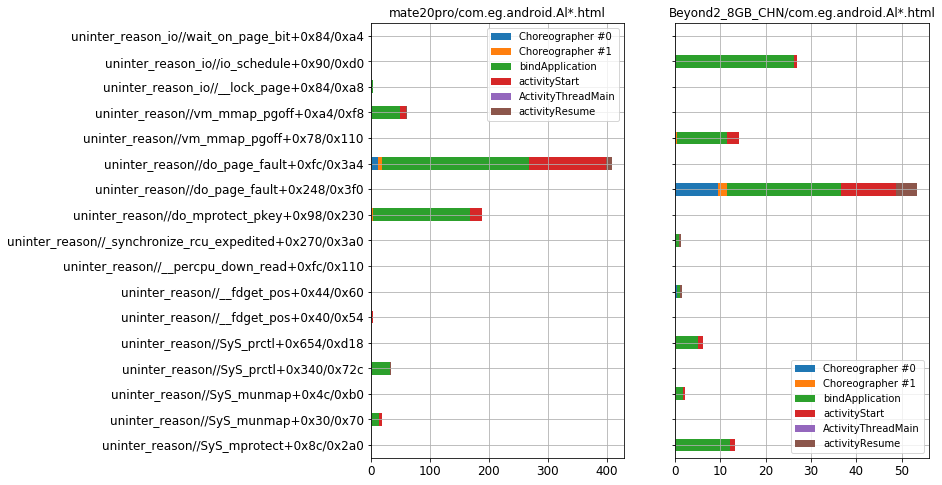

In [17]:
fig,axes = plt.subplots(nrows=1, ncols=2, sharey=True)
df1.plot(kind='barh', ax=axes[0], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group1.title)
df2.plot(kind='barh', ax=axes[1], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group2.title)

### Number of Running Cores

mate20pro/com.eg.android.Al*.html,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume
core0,0,0,2,3,0,0
core1,0,4,7,9,0,1
core2,2,0,8,5,0,0
core3,2,0,1,2,0,0
core4,16,6,114,27,3,4
core5,4,14,65,67,25,11
core6,49,32,3411,737,33,120
core7,52,28,1176,460,10,120


Beyond2_8GB_CHN/com.eg.android.Al*.html,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume
core0,2,3,2,3,0,3
core1,1,2,5,4,0,2
core2,5,2,0,6,0,3
core3,7,3,6,4,0,5
core4,31,3,552,115,8,78
core5,43,7,513,100,24,30
core6,38,6,408,103,17,36
core7,46,13,1197,177,0,57


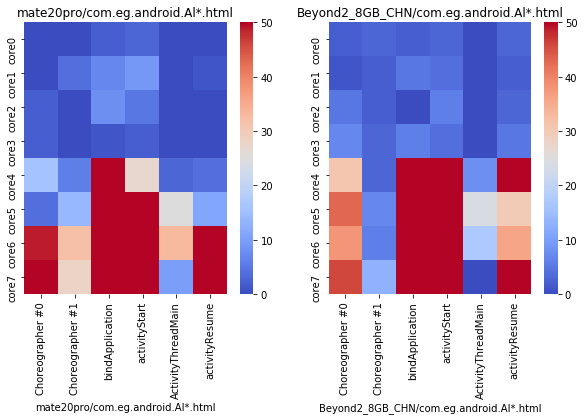

In [18]:
df1 = group1.get(group1.cores(), func='sum')
df1 = df1.dropna(axis=1)
df1.columns.name = group1.title
display(df1)

df2 = group2.get(group2.cores(), func='sum')
df2 = df2.dropna(axis=1)
df2.columns.name = group2.title
display(df2)

plt.figure(figsize=(10, 5))
#sb.palplot(sb.color_palette("hls", 8))
subplot(1,2,1, title=group1.title)
sb.heatmap(data=df1, cmap='coolwarm', center=25, vmax = 50);
subplot(1,2,2, title=group2.title)
sb.heatmap(data=df2, cmap='coolwarm', center=25, vmax = 50);

In [19]:
for idx in range(6):
    display(group2.parsers_of_testing[idx].get(group2.cores()))

,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,0,2,1,0,0,0,NaN
core1,0,2,4,0,0,0,NaN
core2,2,0,0,1,0,0,NaN
core3,1,0,0,0,0,0,NaN
core4,5,1,64,14,0,11,NaN
core5,8,0,89,31,0,11,NaN
core6,29,1,57,1,9,4,NaN
core7,15,0,267,10,0,1,NaN


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,0,0,0,0,0,0,NaN
core1,0,0,0,0,0,0,NaN
core2,0,0,0,0,0,0,NaN
core3,0,0,0,0,0,0,NaN
core4,0,0,69,24,0,16,NaN
core5,2,2,114,24,8,9,NaN
core6,5,1,77,3,0,3,NaN
core7,1,0,220,45,0,13,NaN


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,2,0,1,1,0,0,NaN
core1,0,0,1,1,0,0,NaN
core2,0,0,0,1,0,0,NaN
core3,0,0,1,0,0,1,NaN
core4,7,0,120,16,0,9,NaN
core5,7,4,69,7,8,3,NaN
core6,1,0,56,26,0,4,NaN
core7,16,2,153,7,0,17,NaN


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,0,0,0,0,0,3,NaN
core1,0,0,0,1,0,0,NaN
core2,0,0,0,2,0,2,NaN
core3,4,0,1,0,0,2,NaN
core4,4,0,69,19,0,17,NaN
core5,13,0,72,14,0,6,NaN
core6,2,0,39,6,8,8,NaN
core7,8,3,283,53,0,7,NaN


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,0,0,0,0,0,0,NaN
core1,1,0,0,0,0,0,NaN
core2,0,0,0,0,0,0,NaN
core3,1,3,3,1,0,0,NaN
core4,11,1,138,21,0,8,NaN
core5,6,1,88,14,8,0,NaN
core6,0,4,135,28,0,13,NaN
core7,5,4,83,38,0,9,NaN


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,0,1,0,2,0,0,NaN
core1,0,0,0,2,0,2,NaN
core2,3,2,0,2,0,1,NaN
core3,1,0,1,3,0,2,NaN
core4,4,1,92,21,8,17,NaN
core5,7,0,81,10,0,1,NaN
core6,1,0,44,39,0,4,NaN
core7,1,4,191,24,0,10,NaN
